In [148]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from datetime import datetime,timedelta
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,MinMaxScaler
from sklearn.model_selection import RepeatedKFold,train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score

import api.util
from api.predictions_converter import PredictionsConverter
from api.op_dp import OpDataProvider

from IPython.display import display
pd.options.display.max_columns = None
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
classes=['winner_away', 'winner_draw', 'winner_home']
dp=OpDataProvider(load=False, exclude=['country_id'])
data, labels, info, df=dp.provide_data()
#df=dp._load_data()
#df=dp._provide_odds()

In [150]:
df.head()

,bn,country,ds,liga,mid,odds_away,odds_draw,odds_home,sc1,sc2,t1,t2,tid1,tid2,winner,oddsprob_home,oddsprob_draw,oddsprob_away,drift_home,drift_away,drift_draw
0,0.461538,greece,2014-01-18 15:15:00+00:00,super-league,xzLYjsqg,27.83,11.00,1.06,2,0,olympiacos piraeus,levadiakos,0,506,home,0.881373,0.085437,0.033191,-0.072516,0.139235,0.086659
1,0.461538,spain,2013-02-16 17:00:00+00:00,segunda-division,M5Tqms6i,2.47,3.16,2.85,2,2,guadalajara,almeria,1,1444,draw,0.333431,0.298337,0.368232,-0.055178,0.054568,-0.016432
2,0.461538,germany,2013-09-28 13:30:00+00:00,bundesliga,EZp8Xc0a,17.23,8.23,1.15,1,0,bayern munich,wolfsburg,2,64,home,0.824268,0.117686,0.058046,-0.016230,0.091752,0.039680
3,0.846154,france,2019-01-13 20:00:00+00:00,ligue-1,UJjJ4QAp,4.42,3.91,1.78,1,1,marseille,monaco,3,399,draw,0.535805,0.249926,0.214269,0.097888,-0.233988,-0.080705
4,0.538462,germany,2015-02-01 14:30:00+00:00,bundesliga,G25l1ArF,3.35,3.45,2.21,2,0,werder bremen,hertha berlin,4,420,home,0.428344,0.277868,0.293787,-0.098189,0.105136,0.010880


# Analysis

In [51]:
data_train, data_test, labels_train, labels_test, info_train, info_test = train_test_split(data, labels, info, test_size=0.2, random_state=42)
print(data_train.shape, data_test.shape)

(119680, 4) (29921, 4)


df.isnull().any()

- **prevalence** - percent of winners
- **Sensitivity** is the probability that our test outputs positive given that the case is actually positive.
- **Specificity** is the probability that the test outputs negative given that the case is actually negative.
- **Positive predictive value (PPV)** is the probability that subjects with a positive prediction truly wins.
- **Negative predictive value (NPV)** is the probability that subjects with a negative prediction truly lost.
- **The area under the ROC** curve is also called AUCROC or C-statistic and is a measure of goodness of fit. 
- **F1 score** is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

In [62]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(1024, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(512, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, epochs=30)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, yhat)
        # store result
        print('>%.3f' % acc)
        results.append(acc)
        break
    return results, model

In [65]:
#results = evaluate_model(data, labels)
results, model = evaluate_model(data_train, labels_train)

# summarize performance
print('Accuracy: %.3f (%.3f)' % (np.mean(results), np.std(results)))

Epoch 1/30
2494/2494 [==============================] - 38s 15ms/step - loss: 0.6088
Epoch 2/30
2494/2494 [==============================] - 35s 14ms/step - loss: 0.5917
Epoch 3/30
2494/2494 [==============================] - 36s 15ms/step - loss: 0.5888
Epoch 4/30
2494/2494 [==============================] - 35s 14ms/step - loss: 0.5884
Epoch 5/30
2494/2494 [==============================] - 37s 15ms/step - loss: 0.5865
Epoch 6/30
2494/2494 [==============================] - 37s 15ms/step - loss: 0.5847
Epoch 7/30
2494/2494 [==============================] - 37s 15ms/step - loss: 0.5856
Epoch 8/30
2494/2494 [==============================] - 37s 15ms/step - loss: 0.5840
Epoch 9/30
2494/2494 [==============================] - 37s 15ms/step - loss: 0.5841
Epoch 10/30
2494/2494 [==============================] - 36s 14ms/step - loss: 0.5846
Epoch 11/30
2494/2494 [==============================] - 37s 15ms/step - loss: 0.5851
Epoch 12/30
2494/2494 [==============================] - 36s 14

In [66]:
yhat = model.predict(data_test)

In [348]:
#model.save('models/op_1024_512_64_16_changedDrift.keras')
model = keras.models.load_model('models/op_1024_512_64_16_changedDrift.keras')
yhat = model.predict(data_test)

In [349]:
from IPython.display import display
class PredictionsConverter:
    def __init__(self, provider,  yhat, y, info):
        self.CLASSES=['HOME','DRAW','AWAY']
        self.DATA_PATH=f'predictions/{provider}/'
        self.LABELS_PREDICTED=yhat
        self.LABELS=y
        self.INFO=info.copy()

    def make_df(self, threshold=0.5):
        df_yhat=pd.DataFrame(data=self.LABELS_PREDICTED, columns=['prob_away', 'prob_draw', 'prob_home'])
        df_y=pd.DataFrame(data=self.LABELS, columns=['winner_away', 'winner_draw', 'winner_home'])
        df_i=self.INFO.reset_index(drop=True)
        df_preds=pd.concat([df_i,df_y,df_yhat], axis=1)
        if threshold=='max':
            a=df_yhat.rank(method='max', axis=1)
            df_preds['pred_home']=a['prob_home'].apply(lambda x: 1 if x>2 else 0)
            df_preds['pred_draw']=a['prob_draw'].apply(lambda x: 1 if x>2 else 0)
            df_preds['pred_away']=a['prob_away'].apply(lambda x: 1 if x>2 else 0)
        else:
            df_preds['pred_home']=np.where(df_preds['prob_home']>threshold,1,0)
            df_preds['pred_draw']=np.where(df_preds['prob_draw']>threshold,1,0)
            df_preds['pred_away']=np.where(df_preds['prob_away']>threshold,1,0)
        df_preds=df_preds[(df_preds['pred_home']==1) | (df_preds['pred_draw']==1) |(df_preds['pred_away']==1)]
        df_preds['winner_home']=df_preds['winner_home'].astype(int)
        df_preds['winner_draw']=df_preds['winner_draw'].astype(int)
        df_preds['winner_away']=df_preds['winner_away'].astype(int)
        df_preds['pred_home']=df_preds['pred_home'].astype(int)
        df_preds['pred_draw']=df_preds['pred_draw'].astype(int)
        df_preds['pred_away']=df_preds['pred_away'].astype(int)
        df_preds['win']=0
        df_preds.loc[(df_preds['winner_home']==df_preds['pred_home']) & (df_preds['winner_home']==1),'win']=1
        df_preds.loc[(df_preds['winner_draw']==df_preds['pred_draw']) & (df_preds['winner_draw']==1),'win']=1
        df_preds.loc[(df_preds['winner_away']==df_preds['pred_away']) & (df_preds['winner_away']==1),'win']=1
        df_preds.loc[df_preds['pred_home']==1,'odds']=df_preds['odds_home']
        df_preds.loc[df_preds['pred_draw']==1,'odds']=df_preds['odds_draw']
        df_preds.loc[df_preds['pred_away']==1,'odds']=df_preds['odds_away']
        df_preds=df_preds.drop_duplicates()
        df_preds['prf']=np.where(df_preds.win>0,df_preds.odds-1, -1)
        self.Y=df_preds[['winner_home','winner_draw','winner_away']].values
        self.YHAT=df_preds[['pred_home','pred_draw','pred_away']].values
        self.DF=df_preds[['ds', 'country', 'liga', 't1', 't2', 'sc1', 'sc2', 'odds_home', 'odds_draw', 'odds_away','winner_home', 'winner_draw', 'winner_away','pred_home','pred_draw','pred_away','prob_home', 'prob_draw', 'prob_away','win','prf']]
    
    def performance_metrics(self):
        display(util.get_performance_metrics(self.Y, self.YHAT, self.CLASSES))
    
    def graph(self,mode='tpfp'):
        if mode == 'tpfp':
            util.get_curve(self.Y, self.YHAT, self.CLASSES)
        elif mode== 'prc':
            util.get_curve(self.Y, self.YHAT, self.CLASSES, curve='prc')
    
    def profit(self):
        print(self.DF.win.mean(), self.DF.prf.sum(), self.DF.prf.sum()/len(self.DF.index),len(self.DF.index))

In [60]:
def odds2prob(df):
    df['odds_away']=1/df['odds_away']
    df['odds_draw']=1/df['odds_draw']
    df['odds_home']=1/df['odds_home']
    df['margin']=df[['odds_away','odds_draw','odds_home']].sum(axis=1)
    df['odds_away']=df['odds_away']/df['margin']
    df['odds_draw']=df['odds_draw']/df['margin']
    df['odds_home']=df['odds_home']/df['margin']
    return df[['odds_away','odds_draw','odds_home']]

In [67]:
conv_bookies=PredictionsConverter('op', odds2prob(info_test.copy()).values, labels_test, info_test.copy())
conv_bookies.make_df()
conv=PredictionsConverter('op', yhat, labels_test, info_test.copy())
conv.make_df()

conv_bookies.profit()
conv.profit()
conv_bookies.performance_metrics()
conv.performance_metrics()

0.6513761467889908 -311.53 -0.024017423483154728 12971
0.5670935008456148 -619.1300000000001 -0.029916888137231222 20695


,Name,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,HOME,6512,2445,3540,474,0.691,0.539,0.932,0.409,0.648,0.838,0.670,0.764,0.5
1,DRAW,3,10363,4,2601,0.799,0.201,0.001,1.000,0.429,0.799,0.500,0.002,0.5
2,AWAY,1934,8612,978,1447,0.813,0.261,0.572,0.898,0.664,0.856,0.735,0.615,0.5


,Name,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,HOME,9216,3419,7180,880,0.611,0.488,0.913,0.323,0.562,0.795,0.618,0.696,0.5
1,DRAW,1,15980,1,4713,0.772,0.228,0.000,1.000,0.500,0.772,0.500,0.000,0.5
2,AWAY,2519,13032,1778,3366,0.751,0.284,0.428,0.880,0.586,0.795,0.654,0.495,0.5


In [68]:
conv_bookies1=PredictionsConverter('op', odds2prob(info_test.copy()).values, labels_test, info_test.copy())
conv_bookies1.make_df(threshold='max')
conv1=PredictionsConverter('op', yhat, labels_test, info_test.copy())
conv1.make_df(threshold='max')

conv_bookies1.profit()
conv1.profit()
conv_bookies1.performance_metrics()
conv1.performance_metrics()

0.5259534075336743 -1171.42 -0.03915304655904275 29919
0.5121494702363046 -1210.19 -0.04044887863899194 29919


,Name,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,HOME,11350,6460,9881,2228,0.595,0.454,0.836,0.395,0.535,0.744,0.616,0.652,0.5
1,DRAW,23,22561,30,7305,0.755,0.245,0.003,0.999,0.434,0.755,0.501,0.006,0.5
2,AWAY,4363,16568,4338,4650,0.700,0.301,0.484,0.792,0.501,0.781,0.638,0.493,0.5


,Name,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
0,HOME,11115,6448,9893,2463,0.587,0.454,0.819,0.395,0.529,0.724,0.607,0.643,0.5
1,DRAW,2,22589,2,7326,0.755,0.245,0.000,1.000,0.500,0.755,0.500,0.001,0.5
2,AWAY,4206,16205,4701,4807,0.682,0.301,0.467,0.775,0.472,0.771,0.621,0.469,0.5


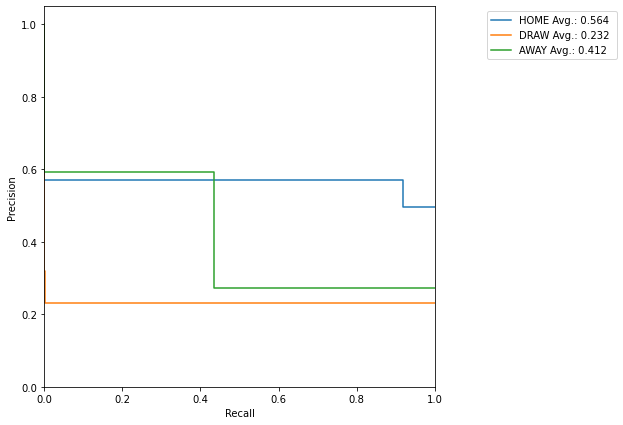

In [238]:
conv.graph(mode='prc')

In [140]:
res.drop_duplicates().to_csv('data/opres.csv', index=False)

## Data manipulations

In [ ]:
COUNTRIES=['england', 'france', 'greece', 'spain', 'italy', 'portugal', 'mexico', 'asia', 'scotland', 'netherlands', 'belgium', 
                        'turkey', 'argentina', 'germany', 'switzerland', 'poland', 'austria', 'europe', 'south-america', 'denmark',
                        'ukraine', 'usa', 'russia', 'japan', 'bulgaria', 'lithuania', 'sweden', 'norway', 'romania', 'brazil', 'estonia',
                        'slovakia', 'north-central-america', 'finland', 'serbia', 'slovenia', 'china', 'hungary', 'czech-republic', 'chile',
                        'belarus', 'croatia', 'paraguay', 'cyprus', 'uruguay', 'ireland', 'colombia', 'south-korea', 'ecuador']
df1=pd.read_csv('data/op/matches.csv', index_col=None)
df1=df1[df1.country.isin(COUNTRIES)]
df1.drop_duplicates().to_csv('data/op/matches.csv', index=False)